### New York City Airbnb Availability Prediction

Data source: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

Given data about Airbnb locations in NYC, let's try to predict whether a given location will be *available 365 days out of the year*.

We will use a tensorflow ANN to make our predictions.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
import tensorflow as tf

2024-07-28 17:51:41.241735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### Visualization

Let's plot all the Airbnb locations on the provided image of NYC. 

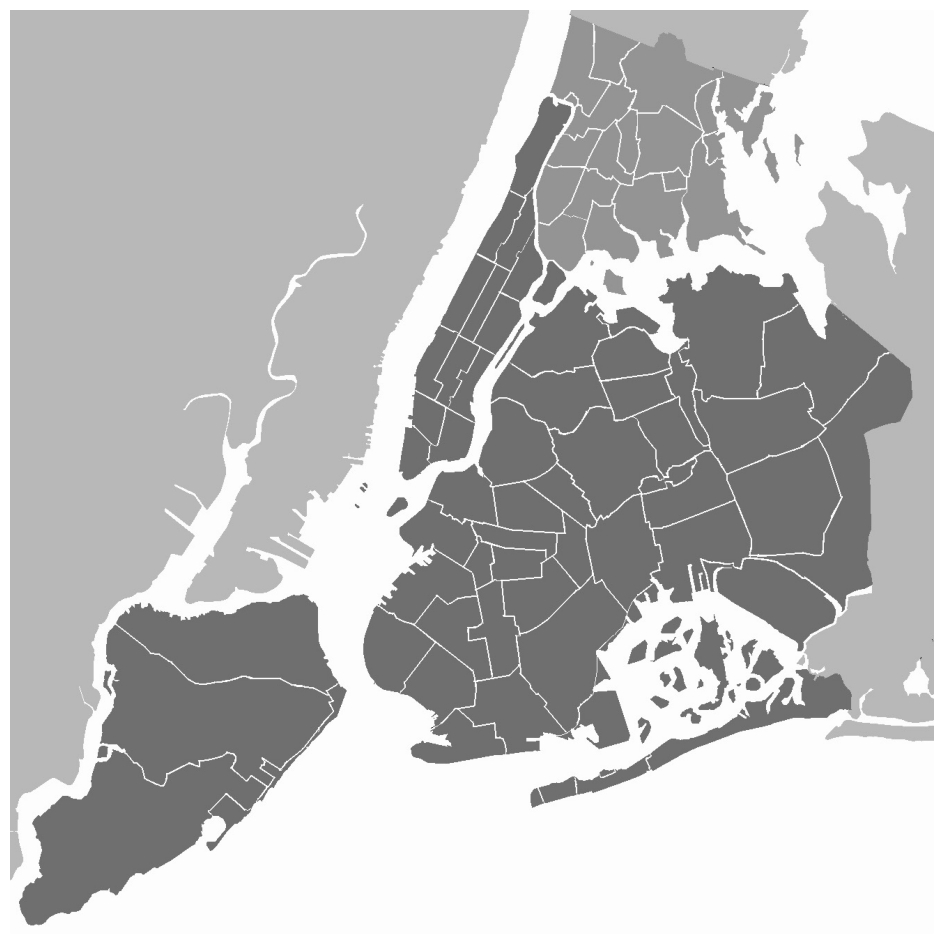

In [4]:
img = Image.open('New_York_City_.png')
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(img, extent=(0,1, 0, 1))
plt.show()

We can use the latitude and longitude values to plot points on the map. 

In [5]:
coords = data.loc[:, ['longitude', 'latitude']].copy()
coords

,longitude,latitude
0,-73.97237,40.64749
1,-73.98377,40.75362
2,-73.94190,40.80902
3,-73.95976,40.68514
4,-73.94399,40.79851
...,...,...
48890,-73.94995,40.67853
48891,-73.93317,40.70184
48892,-73.94867,40.81475
48893,-73.99112,40.75751


Let's apply a MinMaxScaler transform to these two columns so we can plot them along the axes. 

In [6]:
min_max_scaler = MinMaxScaler()

coords = pd.DataFrame(min_max_scaler.fit_transform(coords), columns=coords.columns)
coords

,longitude,latitude
0,0.511921,0.357393
1,0.490469,0.614199
2,0.569257,0.748252
3,0.535649,0.448496
4,0.565324,0.722820
...,...,...
48890,0.554109,0.432502
48891,0.585684,0.488906
48892,0.556517,0.762117
48893,0.476639,0.623612


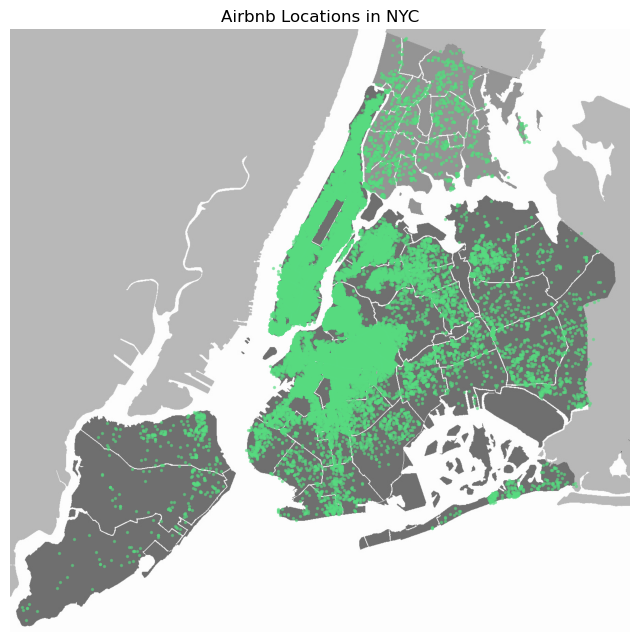

In [7]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img, extent=(-0.02,1.045, -0.02, 1.015))
plt.scatter(x=coords['longitude'], y=coords['latitude'], s=2, c='#57db80', alpha=0.5)
plt.title('Airbnb Locations in NYC')
plt.show()

### Cleaning

Let's start by removing unnecessary columns and dealing with missing values. 

In [8]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
unneeded_columns = ['id', 'name', 'host_id', 'host_name']
data = data.drop(unneeded_columns, axis=1)

In [10]:
print("Total missing values: ", data.isna().sum().sum())

Total missing values:  20104


In [11]:
data.isna().mean()

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.205583
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [12]:
len(data['last_review'].unique())

1765

Because the missing values in the *last_review* column are difficult to deal with, we will drop that column and fill the NaN values in *reviews_per_month* with 0s (since a missing value implies there are no reviews for the location).

In [13]:
data = data.drop('last_review', axis=1)

data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [14]:
data.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

### Creating Labels

We want to be able to predict if a location will be available 365 days of the year.

Let us change the *availability_365* column to be a simple binary column (where 1 denotes 365-availability and 0 denotes otherwise).

In [15]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [16]:
data['availability_365'] = data['availability_365'].apply(lambda x: 1 if x == 365 else 0)

In [17]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,1
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,1
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


We can see from the class distribution that we are dealing with severely skewed classes (365-availability only occurs in 2.6485% of the data).

In [18]:
data['availability_365'].value_counts() / len(data['availability_365'])

availability_365
0    0.973515
1    0.026485
Name: count, dtype: float64

### Encoding features 

Let's get a list of the unique values for each categorical feature, so we can decide on how to encode them.

In [19]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,1
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,1
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [20]:
{feature: list(data[feature].unique()) for feature in data.columns if data.dtypes[feature] == 'object'}

{'neighbourhood_group': ['Brooklyn',
  'Manhattan',
  'Queens',
  'Staten Island',
  'Bronx'],
 'neighbourhood': ['Kensington',
  'Midtown',
  'Harlem',
  'Clinton Hill',
  'East Harlem',
  'Murray Hill',
  'Bedford-Stuyvesant',
  "Hell's Kitchen",
  'Upper West Side',
  'Chinatown',
  'South Slope',
  'West Village',
  'Williamsburg',
  'Fort Greene',
  'Chelsea',
  'Crown Heights',
  'Park Slope',
  'Windsor Terrace',
  'Inwood',
  'East Village',
  'Greenpoint',
  'Bushwick',
  'Flatbush',
  'Lower East Side',
  'Prospect-Lefferts Gardens',
  'Long Island City',
  'Kips Bay',
  'SoHo',
  'Upper East Side',
  'Prospect Heights',
  'Washington Heights',
  'Woodside',
  'Brooklyn Heights',
  'Carroll Gardens',
  'Gowanus',
  'Flatlands',
  'Cobble Hill',
  'Flushing',
  'Boerum Hill',
  'Sunnyside',
  'DUMBO',
  'St. George',
  'Highbridge',
  'Financial District',
  'Ridgewood',
  'Morningside Heights',
  'Jamaica',
  'Middle Village',
  'NoHo',
  'Ditmars Steinway',
  'Flatiron Distr

It appears that all three categorical features are nominal (no ordering), so we will perform one-hot encoding on them.

In [21]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [22]:
data = onehot_encode(
    data,
    columns=['neighbourhood_group', 'neighbourhood', 'room_type'],
    prefixes=['G', 'N', 'R']
)
data

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,G_Bronx,G_Brooklyn,...,N_Williamsburg,N_Willowbrook,N_Windsor Terrace,N_Woodhaven,N_Woodlawn,N_Woodrow,N_Woodside,R_Entire home/apt,R_Private room,R_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting/Scaling

Out data is now in fully-numeric form, so let's scale the data so that each column has mean 0 and unit variance. <br>
First, we need to split the data into X (features) and y (target).

In [23]:
data

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,G_Bronx,G_Brooklyn,...,N_Williamsburg,N_Willowbrook,N_Windsor Terrace,N_Woodhaven,N_Woodlawn,N_Woodrow,N_Woodside,R_Entire home/apt,R_Private room,R_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
y = data['availability_365'].copy()
X = data.drop('availability_365', axis=1).copy()

In [25]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [26]:
X

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,G_Bronx,G_Brooklyn,G_Manhattan,...,N_Williamsburg,N_Willowbrook,N_Windsor Terrace,N_Woodhaven,N_Woodlawn,N_Woodrow,N_Woodside,R_Entire home/apt,R_Private room,R_Shared room
0,-1.493849,-0.437652,-0.015493,-0.293996,-0.320414,-0.551511,-0.034716,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
1,0.452436,-0.684639,0.300974,-0.293996,0.487665,-0.445079,-0.156104,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
2,1.468399,0.222497,-0.011329,-0.196484,-0.522433,-0.682986,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
3,-0.803398,-0.164450,-0.265335,-0.293996,5.538156,2.221978,-0.186451,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
4,1.275660,0.177216,-0.302811,0.144807,-0.320414,-0.620379,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,-0.924616,0.048089,-0.344452,-0.245240,-0.522433,-0.682986,-0.156104,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
48891,-0.497141,0.411637,-0.469373,-0.147729,-0.522433,-0.682986,-0.156104,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
48892,1.573480,0.075821,-0.157070,0.144807,-0.522433,-0.682986,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
48893,0.523774,-0.843881,-0.406912,-0.293996,-0.522433,-0.682986,-0.034716,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,-0.916680,6.414894


Now that the data has been scaled, and we only need to split it into train and test sets. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=200)

### Modeling

Since we are dealing with tabular data, we will use a simple 2-hidden layer neural network.

In [28]:
X.shape

(48895, 236)

In [29]:
inputs = tf.keras.Input(shape=(X.shape[1],), name='input_layer')

hidden_1 = tf.keras.layers.Dense(64, activation='relu', name='hidden_1')(inputs)
hidden_2 = tf.keras.layers.Dense(64, activation='relu', name='hidden_2')(hidden_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(hidden_2)

model = tf.keras.Model(inputs, outputs)

2024-07-28 17:51:44.976105: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Let's generate a summary and graphical representation of the model for better understanding.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 236)]             0         
                                                                 
 hidden_1 (Dense)            (None, 64)                15168     
                                                                 
 hidden_2 (Dense)            (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0
_________________________________________________________________
None


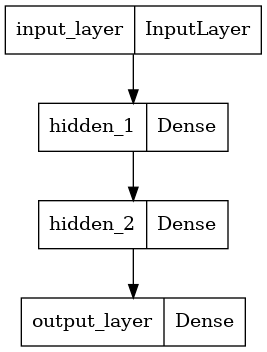

In [30]:
print(model.summary())
tf.keras.utils.plot_model(model)

In [31]:
# !pip install pydot 

### Training

Let us compare some class weights before fitting the model (since our classes are so skewed).

In [36]:
class_weight = dict(
    enumerate(
        class_weight.compute_class_weight(
            class_weight='balanced',
            classes=y_train.unique(),
            y=y_train
        )
    )
)

In [37]:
class_weight

{0: 0.512902742394725, 1: 19.875725900116144}

In [38]:
batch_size = 32
epochs=60

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    class_weight=class_weight,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/60
856/856 [==============================] - 6s 7ms/step - loss: 0.6844 - accuracy: 0.6399 - auc: 0.6793 - val_loss: 0.7365 - val_accuracy: 0.5576 - val_auc: 0.7404 - lr: 0.0010
Epoch 2/60
856/856 [==============================] - 4s 5ms/step - loss: 0.5736 - accuracy: 0.6987 - auc: 0.7787 - val_loss: 0.6150 - val_accuracy: 0.6897 - val_auc: 0.7568 - lr: 0.0010
Epoch 3/60
856/856 [==============================] - 4s 5ms/step - loss: 0.5491 - accuracy: 0.7298 - auc: 0.7996 - val_loss: 0.5046 - val_accuracy: 0.7978 - val_auc: 0.7565 - lr: 0.0010
Epoch 4/60
856/856 [==============================] - 4s 5ms/step - loss: 0.5371 - accuracy: 0.7393 - auc: 0.8081 - val_loss: 0.6096 - val_accuracy: 0.6578 - val_auc: 0.7572 - lr: 0.0010
Epoch 5/60
856/856 [==============================] - 4s 5ms/step - loss: 0.5278 - accuracy: 0.7313 - auc: 0.8161 - val_loss: 0.5850 - val_accuracy: 0.6931 - val_auc: 0.7668 - lr: 0.0010
Epoch 6/60
856/856 [==============================] - 4s 5ms/step

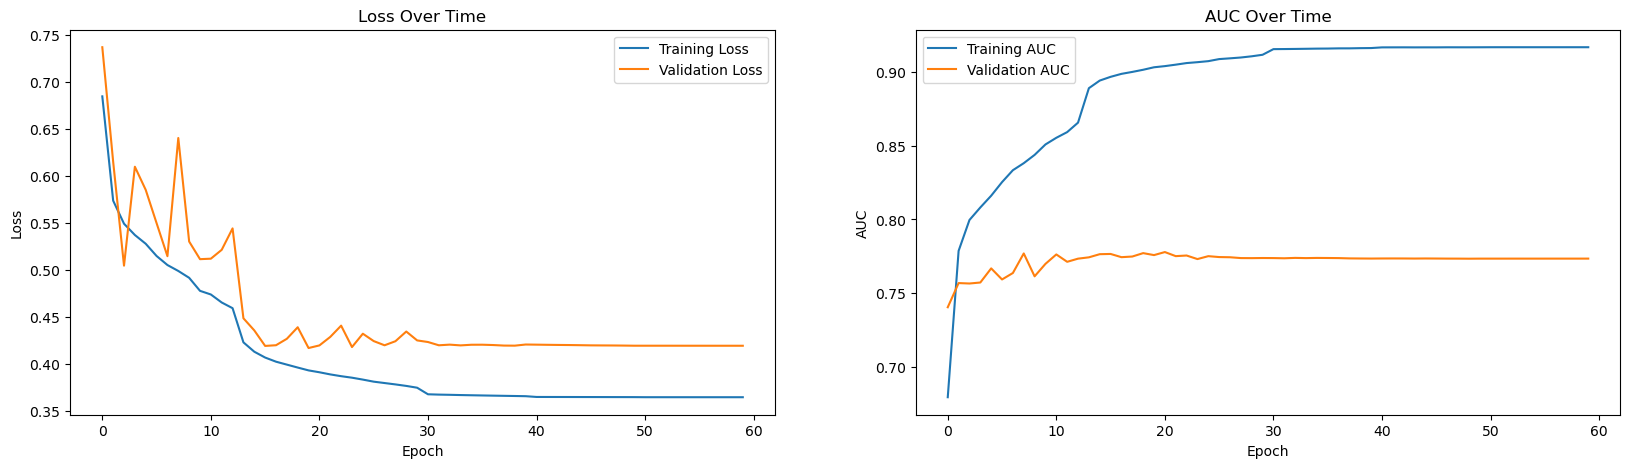

In [40]:
plt.figure(figsize=(20,5))

epochs_range = range(epochs)

train_loss, val_loss = history.history['loss'], history.history['val_loss']
train_auc, val_auc = history.history['auc'], history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Time")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label="Training AUC")
plt.plot(epochs_range, val_auc, label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC Over Time")

plt.show()

### Results

In [41]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy:', results[1])
print('ROC AUC:', results[2])

Accuracy: 0.8141659498214722
ROC AUC: 0.789431095123291


In [47]:
np.sum(y_test == (np.squeeze(model.predict(X_test) > 0.5)).astype(np.int))

459/459 [==============================] - 1s 3ms/step


/tmp/ipykernel_27448/2835860563.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.sum(y_test == (np.squeeze(model.predict(X_test) > 0.5)).astype(np.int))


11943

In [48]:
np.mean(y_test == (np.squeeze(model.predict(X_test) > 0.5)).astype(np.int))

459/459 [==============================] - 2s 4ms/step


/tmp/ipykernel_27448/2521599337.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.mean(y_test == (np.squeeze(model.predict(X_test) > 0.5)).astype(np.int))


0.8141659281477946

In [49]:
y_test == 1

22766    False
16056    False
23124    False
12853    False
30721    False
         ...  
16567    False
46112    False
35990    False
45350    False
32696    False
Name: availability_365, Length: 14669, dtype: bool

In [54]:
y_pred = pd.Series((np.squeeze(model.predict(X_test)) > 0.5).astype(np.int))

459/459 [==============================] - 1s 3ms/step


/tmp/ipykernel_27448/1779413448.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = pd.Series((np.squeeze(model.predict(X_test)) > 0.5).astype(np.int))


In [55]:
y_pred

0        0
1        0
2        0
3        0
4        1
        ..
14664    0
14665    0
14666    1
14667    0
14668    1
Length: 14669, dtype: int64

In [58]:
y_true = y_test.reset_index(drop=True)

In [62]:
positive_indices = y_true[y_true == 1].index

In [66]:
np.mean(y_pred[positive_indices] == y_true[positive_indices])

0.6451612903225806